# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Checkpoint" data-toc-modified-id="Checkpoint-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Checkpoint</a></div><div class="lev1 toc-item"><a href="#Build-Model" data-toc-modified-id="Build-Model-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Build Model</a></div><div class="lev2 toc-item"><a href="#Import-Libraries" data-toc-modified-id="Import-Libraries-21"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Import Libraries</a></div><div class="lev2 toc-item"><a href="#Set-Hyperparameters" data-toc-modified-id="Set-Hyperparameters-22"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Set Hyperparameters</a></div><div class="lev2 toc-item"><a href="#Build-Graph" data-toc-modified-id="Build-Graph-23"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Build Graph</a></div><div class="lev1 toc-item"><a href="#Model-Visualization" data-toc-modified-id="Model-Visualization-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Model Visualization</a></div><div class="lev1 toc-item"><a href="#Train" data-toc-modified-id="Train-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Train</a></div>

# Checkpoint

In [97]:
import h5py
import numpy as np

In [98]:
with h5py.File('/Users/lizhn7/Downloads/EXPERIMENT/COPA/Sentence_Classification_Glove/data/embedding.h5', 'r') as fh:
    embedding = fh['embedding'][:]
    
with h5py.File('/Users/lizhn7/Downloads/EXPERIMENT/COPA/Sentence_Classification_Glove/data/train_2000_2.h5', 'r') as fh:
    xTrain = fh['xTrain'][:]
    yTrain = fh['yTrain'][:]
    
with h5py.File('/Users/lizhn7/Downloads/EXPERIMENT/COPA/Sentence_Classification_Glove/data/test.h5', 'r') as fh:
    x1Test = fh['x1Test'][:]
    x2Test = fh['x2Test'][:]
    yTest = fh['yTest'][:]

In [99]:
xVal = np.vstack((x1Test, x2Test))

l = [0] * 1000
for i in range(len(yTest)):
    if yTest[i] == 1:
        l[i] = 1
        l[i+len(yTest)] = -1
    if yTest[i] == 2:
        l[i] = -1
        l[i+len(yTest)] = 1

yVal = np.array(l)

# Build Model

## Import Libraries

In [17]:
from keras.layers import Lambda, Input, Embedding, Dropout, GRU, RepeatVector, Concatenate, concatenate, TimeDistributed, Dense, BatchNormalization, Activation
from keras.models import Model
import keras.backend as K
from keras.regularizers import l2
from keras.constraints import maxnorm
from keras.callbacks import*
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Set Hyperparameters

In [121]:
MAX_LEN = 22
VOCAB_SIZE = 3371
EMBEDDING_SIZE = 300
GRU_SIZE = 300
DROPOUT_RATE = 0.2
L2_NORM = 1e-4
HIDDEN_SIZE = 600
WEIGHT_CONSTRAINT = 2.
DELTA = 1.
BATCH_SIZE = 200
NUM_EPOCHS = 1024

## Build Graph

In [122]:
def hinge(y_true, y_pred):
    """
    Define hinge loss function
    """
    return K.mean(K.maximum(DELTA - y_true * y_pred, 0.), axis=-1)

In [123]:
def feature_map():
    """
    Build Attention GRU feature maps
    """
    inputs = Input(shape=(MAX_LEN,), name='INPUT')
    emb_seq = Embedding(VOCAB_SIZE, 
                        EMBEDDING_SIZE, 
                        weights=[embedding], 
                        mask_zero=True, 
                        trainable=False, 
                        name='EMBEDDING')(inputs)
    gru = GRU(GRU_SIZE, 
              return_sequences=True, 
              implementation=0, 
              dropout=DROPOUT_RATE, 
              recurrent_dropout=DROPOUT_RATE,
              kernel_regularizer=l2(L2_NORM),
              recurrent_regularizer=l2(L2_NORM),
              name='GRU')(emb_seq)
    gru = Dropout(DROPOUT_RATE, name='DROPOUT')(gru)
    model = Model(inputs=[inputs], outputs=[gru])
    return model

In [124]:
model = feature_map()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
INPUT (InputLayer)           (None, 22)                0         
_________________________________________________________________
EMBEDDING (Embedding)        (None, 22, 300)           1011300   
_________________________________________________________________
GRU (GRU)                    (None, 22, 300)           540900    
_________________________________________________________________
DROPOUT (Dropout)            (None, 22, 300)           0         
Total params: 1,552,200
Trainable params: 540,900
Non-trainable params: 1,011,300
_________________________________________________________________


In [125]:
def relation_networks():
    """
    Build relation networks
    """
    GRU = feature_map()
    inputs = Input(shape=(MAX_LEN,), name='INPUT')
    feaMap = GRU(inputs)
    mlp = TimeDistributed(Dense(HIDDEN_SIZE,
                                activation=None,
                                kernel_regularizer=l2(L2_NORM),
                                kernel_constraint=maxnorm(WEIGHT_CONSTRAINT)),
                          name='MLP_1')(feaMap)
    mlp = BatchNormalization(name='BN_1')(mlp)
    mlp = Activation('elu', name='ELU_1')(mlp)
    mlp = Dropout(DROPOUT_RATE, name='DROPOUT_1')(mlp)
    ewSum = Lambda(lambda x: K.sum(x, axis=1), name='ELEMENT-WISE_SUM')(mlp)
    mlp2 = Dense(HIDDEN_SIZE, 
                 activation=None,
                 kernel_regularizer=l2(L2_NORM),
                 kernel_constraint=maxnorm(WEIGHT_CONSTRAINT),
                 name='MLP_2')(ewSum)
    mlp2 = BatchNormalization(name='BN_2')(mlp2)
    mlp2 = Activation('elu', name='ELU_2')(mlp2)
    mlp2 = Dropout(DROPOUT_RATE, name='DROPOUT_2')(mlp2)
    outputs = Dense(1, 
                    activation='tanh', 
                    kernel_regularizer=l2(L2_NORM),
                    kernel_constraint=maxnorm(WEIGHT_CONSTRAINT),
                    name='OUTPUT')(mlp2)
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(loss=hinge, optimizer='rmsprop')
    return model

# Model Visualization

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
INPUT (InputLayer)           (None, 22)                0         
_________________________________________________________________
model_1 (Model)              (None, 22, 300)           1552200   
_________________________________________________________________
MLP_1 (TimeDistributed)      (None, 22, 600)           180600    
_________________________________________________________________
BN_1 (BatchNormalization)    (None, 22, 600)           2400      
_________________________________________________________________
ELU_1 (Activation)           (None, 22, 600)           0         
_________________________________________________________________
DROPOUT_1 (Dropout)          (None, 22, 600)           0         
_________________________________________________________________
ELEMENT-WISE_SUM (Lambda)    (None, 600)               0         
__________

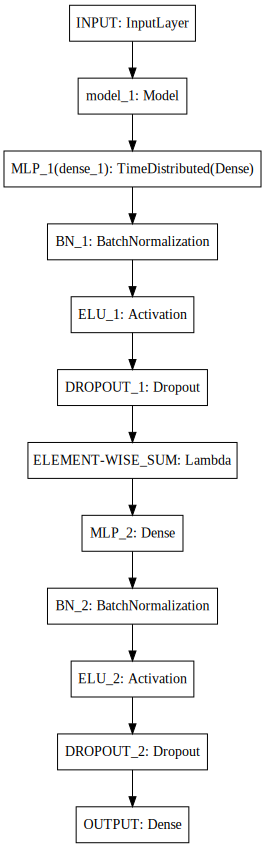

In [126]:
K.clear_session()
model = relation_networks()
model.summary()
SVG(model_to_dot(model).create(prog='dot', format='svg'))

# Train

In [127]:
from tqdm import tqdm
import numpy as np

In [128]:
def accuracy(a1, a2, actu, show=True):
    """
    Calculate Accuracy
    """
    A1 = model.predict(a1)
    A2 = model.predict(a2)
    pred = []
    for i in range(len(A1)):
        if A1[i] > A2[i]:
            pred.append(1)
        else:
            pred.append(2)
    S = sum([1 for i in range(len(pred)) if pred[i] == actu[i]])
    ACC = S / len(actu)
    if show:
        print('Accuracy: \t%.9f' % (ACC))
    return np.array([ACC])

def plot_acc(acc, num_epochs):
    """
    Plot Accuracy
    """
    print('MAX Accuracy: \t%.3f' % (max(acc)))
    epochs = list(range(1, num_epochs+1))
    plt.figure(figsize=(10, 8))
    plt.plot(epochs, acc, label="Accuracy", color="red", linewidth=1)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.xticks([i for i in range(1, len(acc), len(acc)//10)])
    plt.grid(True)  
    plt.legend()
    plt.show()
    
def plot_loss(log):
    """
    Plot Loss
    """
    plt.figure(figsize=(10, 8))
    loss = log['loss']
    if 'val_loss' in log:
        val_loss = log['val_loss']
        plt.plot(val_loss, color="r", label="Val Loss")
    plt.plot(loss, color="g", label="Train Loss")
    plt.ylabel("Loss")
    plt.xlabel("Epochs")
    plt.legend(loc="best")
    plt.show()

In [129]:
def train(model, num_epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, verbose=1, show=True, plot=True):
    """
    Parameters
    ----------
    model :                  training model          
    num_epochs 128:          training epochs   
    batch_size 200:          size of batch 
    verbose :                1
    show True:               show accuracy every epoch
    plot True:               plot accuracy and loss or not
    Returns
    ----------
    The training results
    """
    ACC = []
    history = {}
    for e in range(num_epochs):
        print('EPOCHS', e+1)
        t = model.fit(xTrain, 
                      yTrain,
                      batch_size=batch_size,
                      epochs=1,
                      shuffle=True,
                      validation_data=(xVal, yVal),
                      verbose=verbose)
        for i, j in t.history.items():
            history[i] = history.get(i, []) + j
        ACC.append(accuracy(x1Test, x2Test, yTest, show=show))
    if plot:
        plot_acc(ACC, num_epochs)
        plot_loss(history)
    ACC = sum([list(i) for i in ACC], [])
    return max(ACC)

In [130]:
train(relation_networks(), num_epochs=NUM_EPOCHS//4)

EPOCHS 1
Train on 2000 samples, validate on 1000 samples
Epoch 1/1
2000/2000 [==============================] - 9s - loss: 1.1582 - val_loss: 1.1734
Accuracy: 	0.518000000
EPOCHS 2
Train on 2000 samples, validate on 1000 samples
Epoch 1/1
2000/2000 [==============================] - 8s - loss: 1.1555 - val_loss: 1.1564
Accuracy: 	0.518000000
EPOCHS 3
Train on 2000 samples, validate on 1000 samples
Epoch 1/1
2000/2000 [==============================] - 8s - loss: 1.1848 - val_loss: 1.1487
Accuracy: 	0.518000000
EPOCHS 4
Train on 2000 samples, validate on 1000 samples
Epoch 1/1
2000/2000 [==============================] - 8s - loss: 1.1377 - val_loss: 1.1472
Accuracy: 	0.518000000
EPOCHS 5
Train on 2000 samples, validate on 1000 samples
Epoch 1/1
2000/2000 [==============================] - 8s - loss: 1.1112 - val_loss: 1.1424
Accuracy: 	0.518000000
EPOCHS 6
Train on 2000 samples, validate on 1000 samples
Epoch 1/1
2000/2000 [==============================] - 8s - loss: 1.1046 - val_loss

2000/2000 [==============================] - 9s - loss: 1.0461 - val_loss: 1.0727
Accuracy: 	0.518000000
EPOCHS 49
Train on 2000 samples, validate on 1000 samples
Epoch 1/1
2000/2000 [==============================] - 9s - loss: 1.0286 - val_loss: 1.0678
Accuracy: 	0.518000000
EPOCHS 50
Train on 2000 samples, validate on 1000 samples
Epoch 1/1
2000/2000 [==============================] - 9s - loss: 1.0599 - val_loss: 1.0686
Accuracy: 	0.518000000
EPOCHS 51
Train on 2000 samples, validate on 1000 samples
Epoch 1/1
2000/2000 [==============================] - 8s - loss: 1.0626 - val_loss: 1.0397
Accuracy: 	0.518000000
EPOCHS 52
Train on 2000 samples, validate on 1000 samples
Epoch 1/1
2000/2000 [==============================] - 9s - loss: 1.0557 - val_loss: 1.0403
Accuracy: 	0.518000000
EPOCHS 53
Train on 2000 samples, validate on 1000 samples
Epoch 1/1
2000/2000 [==============================] - 9s - loss: 1.0262 - val_loss: 1.0418
Accuracy: 	0.518000000
EPOCHS 54
Train on 2000 sample

KeyboardInterrupt: 

In [103]:
a = model.predict(xVal[:500])

In [104]:
a

array([[ 0.24379191],
       [ 0.08418044],
       [ 0.22674717],
       [-0.15308015],
       [ 0.40756169],
       [ 0.05775225],
       [-0.08575277],
       [-0.27144909],
       [ 0.15838641],
       [-0.2968986 ],
       [-0.25853518],
       [ 0.07909727],
       [ 0.17884338],
       [-0.27796826],
       [ 0.02813196],
       [ 0.20843229],
       [-0.01775522],
       [-0.22357695],
       [ 0.12967746],
       [ 0.04855088],
       [-0.21450867],
       [-0.2720491 ],
       [-0.06026888],
       [-0.19318107],
       [ 0.41353109],
       [-0.29551032],
       [-0.20800786],
       [-0.03044415],
       [-0.28120646],
       [ 0.16107464],
       [-0.27719367],
       [ 0.22158483],
       [-0.11473616],
       [ 0.0407241 ],
       [-0.20183262],
       [-0.15411952],
       [-0.54120332],
       [-0.01891542],
       [ 0.02868381],
       [-0.23319156],
       [-0.26603058],
       [ 0.18231602],
       [-0.00419778],
       [ 0.43494475],
       [-0.17411925],
       [ 0

In [105]:
b = model.predict(xVal[500:])

In [106]:
b

array([[  2.32238904e-01],
       [ -8.83640498e-02],
       [  3.16985697e-02],
       [ -4.50829357e-01],
       [  4.18731987e-01],
       [  5.60927689e-02],
       [ -1.23054653e-01],
       [ -1.94750831e-01],
       [  1.27786338e-01],
       [ -3.83240789e-01],
       [ -2.13257253e-01],
       [ -2.33909234e-01],
       [  2.63439529e-02],
       [ -1.02819353e-01],
       [  1.81481957e-01],
       [  1.19013235e-01],
       [ -1.17485352e-01],
       [ -9.08195525e-02],
       [ -1.30913511e-01],
       [ -1.07863816e-02],
       [ -1.78052157e-01],
       [ -2.58877268e-03],
       [ -4.75778524e-03],
       [ -1.81224003e-01],
       [  3.66369814e-01],
       [ -1.54159889e-01],
       [ -1.90849200e-01],
       [ -1.03060357e-01],
       [ -2.52420366e-01],
       [  1.73553959e-01],
       [ -3.01830262e-01],
       [  2.47940689e-01],
       [ -1.51643515e-01],
       [ -2.03894246e-02],
       [ -1.26680881e-01],
       [ -1.58673003e-01],
       [ -4.10824627e-01],
 

In [33]:
history = model.fit(xTrain, 
                    yTrain,
                    batch_size=BATCH_SIZE,
                    epochs=3,
                    shuffle=True,
                    verbose=1)

Epoch 1/3
2000/2000 [==============================] - 8s - loss: 0.6280     
Epoch 2/3
2000/2000 [==============================] - 6s - loss: 0.6068     
Epoch 3/3
2000/2000 [==============================] - 7s - loss: 0.5909     
